In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["cf_xarray", "palettable", "seawater"]
_colab_install_missing_deps(deps)

# Plotting Glider data with Python tools

Created: 2016-11-15

Updated: 2022-05-25

In this notebook we demonstrate how to obtain and plot glider data using cf-xarray . We will explore data from the Rutgers University RU29 [Challenger](https://challenger.marine.rutgers.edu/) glider that was launched from Ubatuba, Brazil on June 23, 2015 to travel across the Atlantic Ocean. After 282 days at sea, the Challenger was picked up off the coast of South Africa, on March 31, 2016. For more information on this ground breaking excusion see: [https://marine.rutgers.edu/announcements/the-challenger-glider-mission-south-atlantic-mission-complete](https://marine.rutgers.edu/announcements/the-challenger-glider-mission-south-atlantic-mission-complete)

Data collected from this glider mission are available on the IOOS Glider DAC THREDDS via OPeNDAP.

In [2]:
url = (
    "https://data.ioos.us/thredds/dodsC/deployments/rutgers/"
    "ru29-20150623T1046/ru29-20150623T1046.nc3.nc"
)

In [3]:
import cf_xarray

print(cf_xarray.__version__)
import xarray as xr

xr.set_options(keep_attrs=True)
ds = xr.open_dataset(url)

0.8.9


In [4]:
temp = ds.cf["sea_water_temperature"].squeeze()
salt = ds.cf["sea_water_temperature"].squeeze()
dens = ds.cf["sea_water_density"].squeeze()

temp

<xarray.DataArray 'temperature' (profile: 542, obs: 483)> Size: 1MB
[261786 values with dtype=float32]
Coordinates:
    trajectory      <U18 72B 'ru29-20150623T1046'
    temperature_qc  (profile, obs) float32 1MB ...
    time            (profile) datetime64[ns] 4kB 2015-06-23T10:57:59.29022771...
    latitude        (profile) float64 4kB -25.49 -25.51 -25.53 ... -34.07 -34.07
    longitude       (profile) float64 4kB -44.91 -44.92 -44.92 ... 13.48 13.48
    depth           (profile, obs) float32 1MB 8.99 15.81 22.42 ... nan nan nan
Dimensions without coordinates: profile, obs
Attributes: (12/14)
    _ChunkSizes:          1
    actual_range:         [ 3.744  24.5387]
    ancillary_variables:  temperature_qc
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ...                   ...
    observation_type:     measured
    platform:             platform
    standard_name:        sea_water_temperature
    units:                Celsius
    valid_max:            40.0
    valid_min:            -5.0

We squeezed out the trajectory coordinate b/c we are interested in plotting only the profiles as a section.

Glider data is not something trivial to visualize. The very first thing to do is to plot the glider track to check its path.

In [5]:
x = temp.cf["X"]
y = temp.cf["Y"]

location = y.mean(), x.mean()  # Track center.
locations = list(zip(y, x))  # Track points.

In [6]:
import folium

tiles = (
    "http://services.arcgisonline.com/arcgis/rest/services/"
    "World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}"
)

m = folium.Map(location, tiles=tiles, attr="ESRI", zoom_start=4)

folium.CircleMarker(locations[0], fill_color="green", radius=10).add_to(m)
folium.CircleMarker(locations[-1], fill_color="red", radius=10).add_to(m)

line = folium.PolyLine(
    locations=locations,
    color="orange",
    weight=8,
    opacity=0.6,
    popup="Slocum Glider ru29 Deployed on 2015-06-23",
).add_to(m)

m

One might be interested in a the individual profiles of each dive. Lets extract the deepest dive and plot it.

In [7]:
import numpy as np
import numpy.ma as ma

# Find the deepest profile.
idx = np.nonzero(~ma.masked_invalid(temp[:, -1]).mask)[0][0]

z = temp.cf["Z"]
t = temp.cf["T"]

vmin, vmax = z.attrs["actual_range"]
z = ma.masked_outside(z.to_numpy(), vmin, vmax)

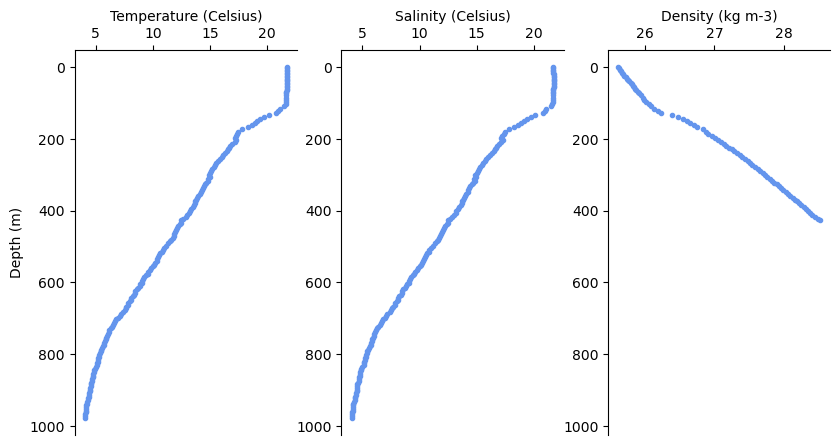

In [8]:
import matplotlib.pyplot as plt

ncols = 3
fig, (ax0, ax1, ax2) = plt.subplots(
    sharey=True, sharex=False, ncols=ncols, figsize=(3.25 * ncols, 5)
)

kw = dict(linewidth=2, color="cornflowerblue", marker=".")
ax0.plot(temp[idx], z[idx], **kw)
ax1.plot(salt[idx], z[idx], **kw)
ax2.plot(dens[idx] - 1000, z[idx], **kw)


def spines(ax):
    ax.spines["right"].set_color("none")
    ax.spines["bottom"].set_color("none")
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_ticks_position("left")


[spines(ax) for ax in (ax0, ax1, ax2)]

ax0.set_ylabel("Depth (m)")
ax0.set_xlabel(f"Temperature ({temp.units})")
ax0.xaxis.set_label_position("top")

ax1.set_xlabel(f"Salinity ({salt.units})")
ax1.xaxis.set_label_position("top")

ax2.set_xlabel(f"Density ({dens.units})")
ax2.xaxis.set_label_position("top")

ax0.invert_yaxis()

We can also visualize the whole track as a cross-section.

In [9]:
import numpy as np
import seawater as sw


def distance(x, y, units="km"):
    dist, pha = sw.dist(x, y, units=units)
    return np.r_[0, np.cumsum(dist)]


def plot_glider(x, y, z, t, data, cmap=plt.cm.viridis, figsize=(11, 3.75)):
    fig, ax = plt.subplots(figsize=figsize)
    dist = distance(x, y, units="km")
    z = np.abs(z)
    dist, z = np.broadcast_arrays(dist[..., np.newaxis], z)
    cs = ax.scatter(dist, z, s=5, c=data, cmap=cmap)
    kw = dict(orientation="vertical", extend="both", shrink=0.65)
    cbar = fig.colorbar(cs, **kw)

    ax.invert_yaxis()
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Depth (m)")
    return fig, ax, cbar

Data collected from 2015-06-23T10:57:59.290227712 to 2016-03-31T09:25:31.420480512


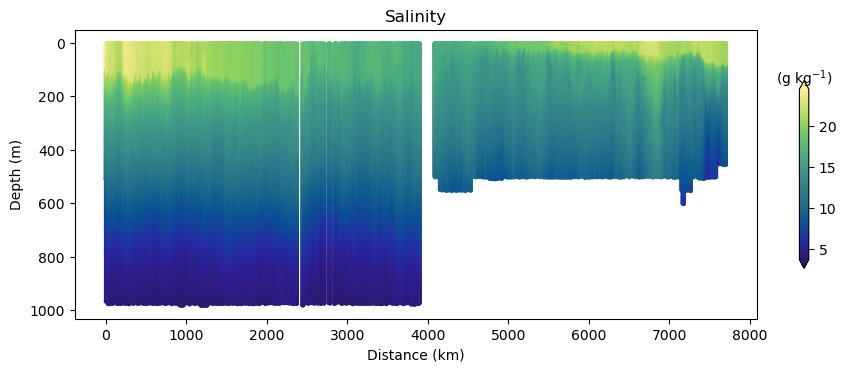

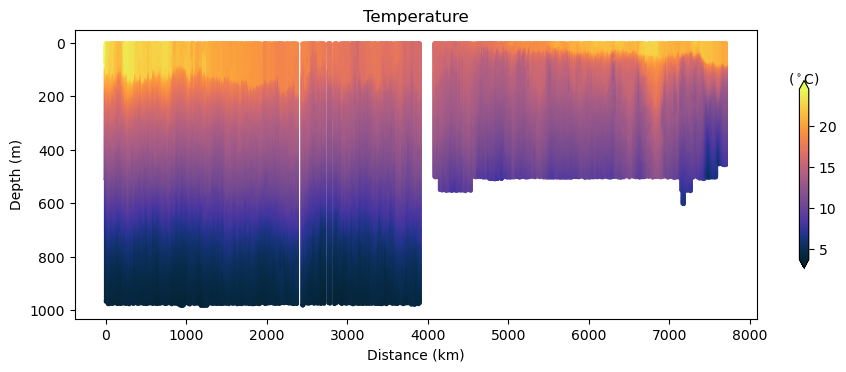

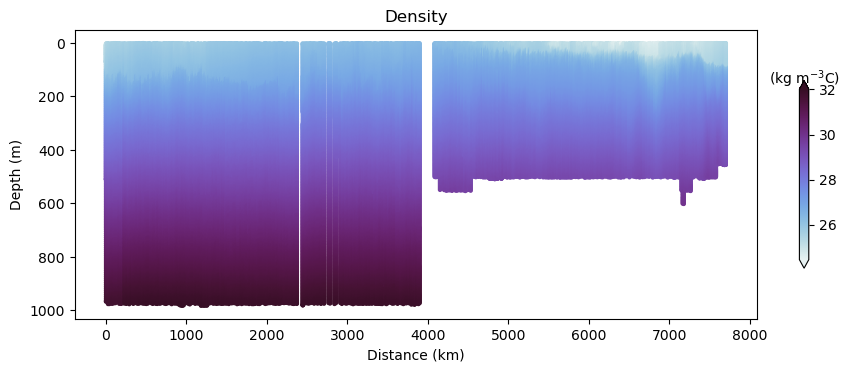

In [10]:
from palettable import cmocean

haline = cmocean.sequential.Haline_20.mpl_colormap
thermal = cmocean.sequential.Thermal_20.mpl_colormap
dense = cmocean.sequential.Dense_20.mpl_colormap


fig, ax, cbar = plot_glider(x, y, z, t, salt, cmap=haline)
cbar.ax.set_xlabel("(g kg$^{-1}$)")
cbar.ax.xaxis.set_label_position("top")
ax.set_title("Salinity")

fig, ax, cbar = plot_glider(x, y, z, t, temp, cmap=thermal)
cbar.ax.set_xlabel(r"($^\circ$C)")
cbar.ax.xaxis.set_label_position("top")
ax.set_title("Temperature")

fig, ax, cbar = plot_glider(x, y, z, t, dens - 1000, cmap=dense)
cbar.ax.set_xlabel(r"(kg m$^{-3}$C)")
cbar.ax.xaxis.set_label_position("top")
ax.set_title("Density")

print(f"Data collected from {t[0].to_numpy()} to {t[-1].to_numpy()}")

Glider cross-section also very be useful but we need to be careful when interpreting those due to the many turns the glider took,
and the time it took to complete the track.

Note that the `x-axis` can be either time or distance. Note that this particular track took ~281 days to complete!

For those interested into more fancy ways to plot glider data check [@lukecampbell's](https://github.com/lukecampbell) [profile_plots.py](https://github.com/ioos/glider-dac-status/blob/master/status/profile_plots.py) script.